In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel, LdaSeqModel
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from konlpy.tag import Okt

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 
              'comp.sys.ibm.pc.hardware', 'sci.crypt']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
print(len(newsgroups_train.data))

3219


In [3]:
def my_tokenizer(doc):
    tokens = RegexpTokenizer(r"[\w']+").tokenize(doc)
    return [WordNetLemmatizer().lemmatize(token) for token in tokens if len(token) > 1]

In [4]:
cv = CountVectorizer(tokenizer=my_tokenizer, max_features=2000, min_df=3, max_df=0.5, stop_words='english')
review_cv = cv.fit_transform(newsgroups_train.data)
review_cv.shape

c:\Users\admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


(3219, 2000)

In [5]:
lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                topic_word_prior=0.1, doc_topic_prior=1.0,
                                learning_method='online', n_jobs=-1, random_state=0)
review_topics = lda.fit_transform(review_cv)
review_topics.shape

(3219, 10)

In [6]:
def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}: {', '.join([feature_names[i] for i in topic.argsort()[:-(n_top_words+1):-1]])}")
    print()

In [7]:
print_top_words(lda, cv.get_feature_names_out())

Topic #0: space, nasa, wa, gov, year, launch, orbit, earth, satellite, access
Topic #1: key, chip, clipper, encryption, government, com, phone, escrow, law, use
Topic #2: wa, god, people, say, ha, jesus, don't, christian, thing, believe
Topic #3: key, information, public, message, faq, internet, mail, list, computer, anonymous
Topic #4: scsi, card, bus, ide, bit, driver, mode, drive, speed, work
Topic #5: com, posting, nntp, host, university, article, know, i'm, ca, thanks
Topic #6: com, article, au, sandvik, apple, wa, cc, kent, islam, muslim
Topic #7: drive, db, disk, problem, ___, hard, com, work, port, floppy
Topic #8: com, don't, think, morality, keith, article, moral, sgi, say, caltech
Topic #9: image, file, program, graphic, available, software, data, format, ftp, color



In [8]:
def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1, 
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components=i, max_iter=max_iter, 
                                        topic_word_prior= topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)    
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

n_components: 6, perplexity: 1012.430
n_components: 7, perplexity: 1005.217
n_components: 8, perplexity: 1006.676
n_components: 9, perplexity: 973.813
n_components: 10, perplexity: 975.659
n_components: 11, perplexity: 972.323
n_components: 12, perplexity: 970.600
n_components: 13, perplexity: 969.639
n_components: 14, perplexity: 972.125
n_components: 15, perplexity: 977.948


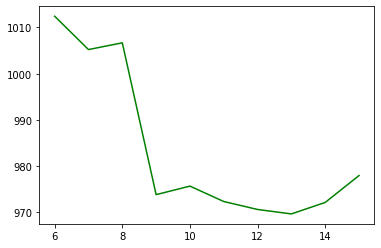

13

In [9]:
show_perplexity(review_cv, start=6, end=15)

In [10]:
lda = LatentDirichletAllocation(n_components=13, max_iter=5,
                                topic_word_prior=0.1, doc_topic_prior=1.0,
                                learning_method='online', n_jobs=-1, random_state=0)
review_topics = lda.fit_transform(review_cv)
review_topics.shape

(3219, 13)

In [11]:
print_top_words(lda, cv.get_feature_names_out(), 15)

Topic #0: com, clipper, access, government, phone, chip, netcom, just, article, right, pat, digex, ti, wa, good
Topic #1: university, point, posting, thanks, nntp, host, problem, help, monitor, looking, i'm, know, just, graphic, cc
Topic #2: nasa, gov, year, research, cost, center, station, space, program, university, wa, billion, money, technology, news
Topic #3: key, encryption, chip, use, public, security, privacy, law, information, clipper, message, bit, ha, government, number
Topic #4: scsi, card, bus, ide, bit, driver, mode, memory, drive, pc, speed, controller, video, o, 16
Topic #5: ca, com, posting, nntp, host, version, know, newsreader, tin, ha, i'm, wrote, university, need, robert
Topic #6: com, article, c, au, sandvik, ibm, apple, kent, net, university, wa, posting, newton, cc, i'm
Topic #7: drive, db, disk, hard, ___, port, floppy, modem, __, work, com, controller, bios, card, problem
Topic #8: article, uk, ac, posting, nntp, host, wa, university, like, just, henry, toront

In [13]:
english_stops = set(stopwords.words('english'))

In [14]:
def my_tokenizer(doc):
    tokens = RegexpTokenizer(r"[\w']{2,}").tokenize(doc.lower())
    return [token for token in tokens if (token not in english_stops) and len(token) > 2]

In [15]:
texts = [my_tokenizer(news) for news in newsgroups_train.data]

In [16]:
dic = Dictionary(texts)
dic.filter_extremes(keep_n=5000, no_below=3, no_above=0.5)
print(len(dic))

5000


In [17]:
corpus = [dic.doc2bow(text) for text in texts]
print('Unique tokens', len(dic), '\n\n', 'Documents', len(corpus))

Unique tokens 5000 

 Documents 3219


In [18]:
model = LdaModel(corpus=corpus, id2word=dic, passes=5, num_topics=10, random_state=7)
model.print_topics(num_words=10)

[(0,
  '0.011*"one" + 0.010*"god" + 0.008*"people" + 0.007*"would" + 0.007*"think" + 0.007*"keith" + 0.006*"atheists" + 0.006*"atheism" + 0.006*"say" + 0.005*"moral"'),
 (1,
  '0.013*"drive" + 0.013*"scsi" + 0.011*"com" + 0.008*"card" + 0.007*"one" + 0.007*"would" + 0.007*"ide" + 0.006*"controller" + 0.006*"university" + 0.006*"get"'),
 (2,
  '0.019*"com" + 0.010*"netcom" + 0.010*"would" + 0.008*"key" + 0.008*"clipper" + 0.008*"article" + 0.008*"one" + 0.007*"escrow" + 0.007*"chip" + 0.007*"nsa"'),
 (3,
  '0.026*"key" + 0.009*"one" + 0.008*"bit" + 0.008*"number" + 0.007*"keys" + 0.007*"chip" + 0.007*"des" + 0.006*"algorithm" + 0.006*"bits" + 0.006*"use"'),
 (4,
  '0.024*"com" + 0.010*"would" + 0.010*"posting" + 0.008*"article" + 0.008*"nntp" + 0.008*"host" + 0.008*"university" + 0.007*"like" + 0.007*"i\'m" + 0.006*"know"'),
 (5,
  '0.012*"article" + 0.008*"university" + 0.007*"science" + 0.007*"posting" + 0.006*"com" + 0.006*"one" + 0.006*"nntp" + 0.006*"host" + 0.005*"theory" + 0.005*

In [21]:
model.get_document_topics(corpus)[1]

[(2, 0.055624876), (4, 0.8433068), (6, 0.07984084)]

In [22]:
def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                 random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)
        
        cm = CoherenceModel(model=model, corpus=corpus, 
                            coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

num_topics: 6, perplexity: -7.714, coherence: -1.732
num_topics: 7, perplexity: -7.720, coherence: -1.685
num_topics: 8, perplexity: -7.693, coherence: -1.503
num_topics: 9, perplexity: -7.704, coherence: -1.579
num_topics: 10, perplexity: -7.706, coherence: -1.720
num_topics: 11, perplexity: -7.714, coherence: -1.805
num_topics: 12, perplexity: -7.732, coherence: -1.921
num_topics: 13, perplexity: -7.741, coherence: -2.185
num_topics: 14, perplexity: -7.750, coherence: -2.222
num_topics: 15, perplexity: -7.775, coherence: -1.843


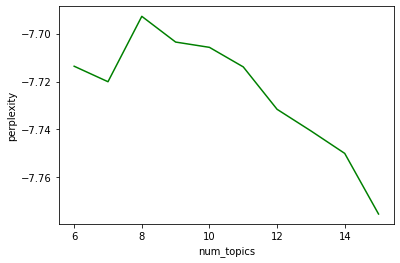

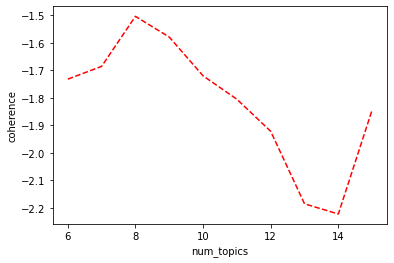

In [23]:
show_coherence(corpus=corpus, dictionary=dic)

In [24]:
model = LdaModel(corpus=corpus, id2word=dic, passes=5, num_topics=13, random_state=7)
model.print_topics(num_words=10)

[(0,
  '0.016*"god" + 0.011*"one" + 0.008*"atheism" + 0.008*"atheists" + 0.007*"moral" + 0.007*"people" + 0.007*"say" + 0.007*"believe" + 0.006*"morality" + 0.005*"must"'),
 (1,
  '0.015*"scsi" + 0.014*"drive" + 0.010*"com" + 0.009*"card" + 0.007*"ide" + 0.007*"one" + 0.007*"controller" + 0.007*"bus" + 0.006*"get" + 0.006*"disk"'),
 (2,
  '0.013*"com" + 0.011*"objective" + 0.010*"would" + 0.010*"one" + 0.010*"frank" + 0.009*"key" + 0.008*"article" + 0.008*"values" + 0.007*"good" + 0.007*"nsa"'),
 (3,
  '0.028*"key" + 0.011*"one" + 0.010*"bit" + 0.009*"number" + 0.007*"keys" + 0.007*"des" + 0.007*"bits" + 0.007*"chip" + 0.006*"use" + 0.006*"public"'),
 (4,
  '0.016*"university" + 0.015*"com" + 0.014*"posting" + 0.013*"nntp" + 0.013*"host" + 0.011*"thanks" + 0.010*"would" + 0.009*"i\'m" + 0.009*"know" + 0.008*"version"'),
 (5,
  '0.013*"article" + 0.009*"posting" + 0.009*"science" + 0.008*"com" + 0.008*"cwru" + 0.008*"nntp" + 0.008*"host" + 0.007*"university" + 0.007*"book" + 0.006*"one"

In [25]:
df = pd.read_csv("./data/petition_sampled.csv")
df.head()

,article_id,start,end,answered,votes,category,title,content
0,58,2017-08-19,2017-11-17,0,21,일자리,국토교통부와 한국주택협회가 행한 부당한 행위와 권력남용에 대한 내용을 청원드립니다.,안녕하세요? 존경하고 지지하는 문재인 대통령님!\n저는 성남시 분당구 정자동 주택전...
1,63,2017-08-20,2017-09-04,0,1,보건복지,살려주세요..,안녕하십니까?\n저는 올해 63세된 홀로 사는 늙은 여자입니다...\n작년 중복날 ...
2,136,2017-08-20,2017-11-18,0,4,육아/교육,고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!,저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...
3,141,2017-08-20,2017-08-27,0,0,기타,한국문화에 창조적요소를 심자,안녕하십니까\n저는 92년 한국을 알게된 종국동포 입니다.\n[저는 한 중소기업에...
4,148,2017-08-20,2017-11-18,0,7,외교/통일/국방,다문화정책 및 할랄 인증 제도,대한민국과 국민을 위해 밤낮 없이 수고하시는 대통령을 비롯한 위정자 분들께\n대한민...


In [26]:
okt = Okt()

In [27]:
def tokenizer(doc):
    return [token for token in okt.nouns(doc) if len(token) > 1]

In [28]:
cv = CountVectorizer(tokenizer=tokenizer, max_df=0.5, min_df=5, max_features=1000)
pet_cv = cv.fit_transform(df.content)
pet_cv.shape

c:\Users\admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(18077, 1000)

In [29]:
lda = LatentDirichletAllocation(n_components=15, n_jobs=-1, random_state=0, topic_word_prior=0.1, doc_topic_prior=1.0)
pet_topics = lda.fit_transform(pet_cv)
print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: 사람, 생각, 병원, 피해자, 가족, 환자, 의사, 피해, 가해자, 소리
Topic #1: 우리, 한국, 북한, 대통령, 정부, 문재인, 미국, 일본, 대한민국, 국가
Topic #2: 아이, 부모, 교사, 가정, 생각, 어린이집, 엄마, 자녀, 지원, 유치원
Topic #3: 불법, 청소년, 이용, 국민, 폐지, 난민, 보호, 조직, 외국인, 장애인
Topic #4: 정책, 주택, 정부, 아파트, 서민, 부동산, 서울, 나라, 투기, 지역
Topic #5: 기업, 일자리, 차량, 회사, 임금, 최저임금, 시간, 사용, 대기업, 인상
Topic #6: 국민, 청원, 세금, 제도, 건강, 반대, 소득, 생각, 혜택, 의료
Topic #7: 조사, 판결, 내용, 대한, 진행, 관련, 확인, 공사, 관리, 발생
Topic #8: 학생, 학교, 교육, 생각, 선수, 시험, 대학, 공부, 문제, 선생님
Topic #9: 연금, 보험, 국민연금, 지급, 방송, 기간, 업무, 근무, 경우, 공무원
Topic #10: 국민, 대통령, 공무원, 여성, 대한민국, 국회의원, 나라, 행정, 국회, 생각
Topic #11: 경찰, 범죄, 국민, 위해, 대한민국, 사건, 범죄자, 수사, 불법, 주차
Topic #12: 처벌, 사건, 기사, 대한, 사고, 피해자, 사실, 폭행, 피해, 언론
Topic #13: 민원, 화폐, 사업, 계획, 정부, 투자, 주민, 거래, 가상, 시장
Topic #14: 생각, 정말, 사람, 제발, 청년, 대출, 지금, 미세먼지, 해결, 요즘



In [30]:
trend_data = pd.DataFrame(pet_topics, columns=[f"Topic{str(i)}" for i in range(1, 16)])
trend_data = pd.concat([trend_data, df.start.map(lambda x: x[:7])], axis=1)
trend_data.head()

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,start
0,0.007369,0.026409,0.007387,0.150744,0.137678,0.010445,0.009597,0.549890,0.006428,0.020279,0.008690,0.009342,0.006861,0.034461,0.014420,2017-08
1,0.124474,0.024728,0.131293,0.031091,0.014192,0.084292,0.014102,0.020990,0.017819,0.156388,0.041951,0.016331,0.014047,0.013633,0.294670,2017-08
2,0.032803,0.018462,0.022179,0.020087,0.021035,0.023408,0.020241,0.037056,0.626235,0.022543,0.018372,0.026903,0.036781,0.025486,0.048409,2017-08
3,0.054810,0.541980,0.008520,0.006637,0.007976,0.237619,0.006464,0.025485,0.012202,0.013043,0.031721,0.005373,0.020707,0.007862,0.019600,2017-08
4,0.015718,0.229752,0.022912,0.091458,0.025006,0.038539,0.065186,0.028034,0.012853,0.020993,0.264646,0.036313,0.064374,0.043587,0.040630,2017-08


In [31]:
trend = trend_data.groupby(['start']).mean()
trend.head()

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15
start,,,,,,,,,,,,,,,
2017-08,0.086998,0.093387,0.117584,0.032022,0.050660,0.082813,0.044019,0.087674,0.073362,0.076891,0.055033,0.034880,0.042607,0.050945,0.071124
2017-09,0.074909,0.064935,0.077813,0.109650,0.050517,0.054772,0.057234,0.057691,0.067992,0.052860,0.061347,0.057057,0.093470,0.050175,0.069578
2017-10,0.080511,0.069377,0.071146,0.056533,0.055838,0.068257,0.055226,0.064893,0.077715,0.069757,0.068449,0.079437,0.062167,0.055200,0.065493
2017-11,0.075646,0.064620,0.062730,0.057313,0.055062,0.061801,0.094488,0.066933,0.071900,0.057171,0.068372,0.067148,0.065038,0.068850,0.062930
2017-12,0.073245,0.066880,0.067807,0.054715,0.056174,0.076395,0.066648,0.067534,0.072879,0.065278,0.073920,0.054096,0.068875,0.066129,0.069426


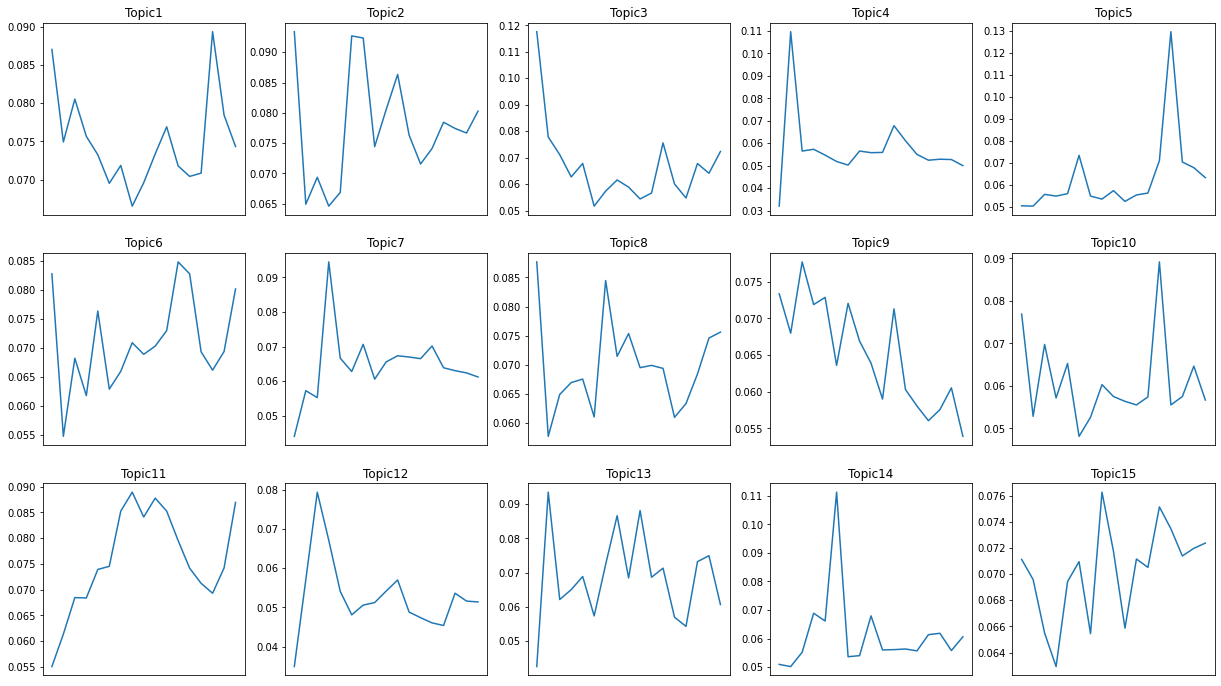

In [32]:
fig, axs = plt.subplots(3, 5, sharex='col', figsize=(21, 12))
for col, ax in zip(trend.columns.tolist(), axs.ravel()):
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])
plt.show()

In [33]:
df_sorted = df.sort_values(by='start')
df_sorted['time'] = df_sorted['start'].map(lambda x: x[:7])
time_slice = list(df_sorted['time'].value_counts().sort_index())
time_tag = sorted(list(set(df_sorted['time'])))
print(time_slice, time_tag)

[83, 906, 298, 1446, 926, 1514, 1304, 1097, 1217, 1301, 1246, 1291, 1390, 1155, 1277, 1187, 439] ['2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12']


In [34]:
okt = Okt()
def tokenizer(doc):
    return [token for token in okt.nouns(doc) if len(token) > 1]
texts = [tokenizer(news) for news in df_sorted['content']]

In [35]:
dictionary = Dictionary(texts)
dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in texts]
len(dictionary), len(corpus)

(2000, 18077)

num_topics: 6, perplexity: -6.903, coherence: -2.204
num_topics: 7, perplexity: -6.885, coherence: -2.174
num_topics: 8, perplexity: -6.886, coherence: -2.181
num_topics: 9, perplexity: -6.875, coherence: -2.323
num_topics: 10, perplexity: -6.860, coherence: -2.298


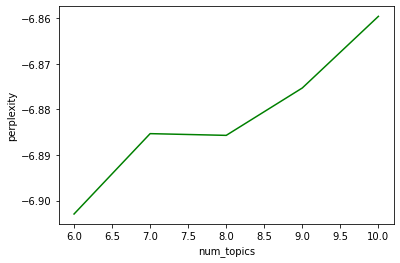

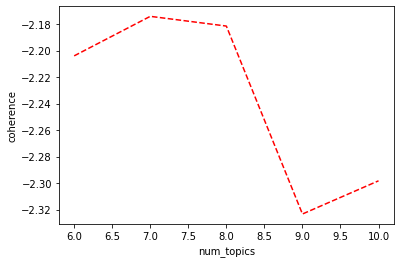

In [36]:
show_coherence(corpus, dictionary, start=6, end=10)

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
ldaseq = LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=time_slice, num_topics=6, random_state=7)

In [39]:
def get_topic_words(topic, top_n_words=10):
    words, _ = zip(*topic)
    return words[:top_n_words]

def print_topic_times(model, topic, time_tag, top_n_words=10):
    topic_times = model.print_topic_times(topic)
    for i in range(len(topic_times)):
        print(time_tag[i]+':', get_topic_words(topic_times[i], top_n_words))

In [40]:
print_topic_times(ldaseq, 4, time_tag, 10)

2017-08: ('청소년', '보호', '경찰', '생각', '범죄', '폐지', '사건', '피해자', '처벌', '사람')
2017-09: ('청소년', '보호', '생각', '범죄', '경찰', '폐지', '사건', '피해자', '처벌', '사람')
2017-10: ('경찰', '범죄', '국민', '대한민국', '사람', '위해', '피해자', '청소년', '사건', '생각')
2017-11: ('경찰', '범죄', '국민', '사람', '대한민국', '위해', '사건', '생각', '피해자', '처벌')
2017-12: ('사람', '경찰', '범죄', '생각', '처벌', '대한민국', '국민', '피해자', '사건', '여성')
2018-01: ('사람', '선수', '처벌', '생각', '피해자', '여성', '범죄', '경찰', '대한민국', '사회')
2018-02: ('사람', '선수', '처벌', '생각', '여성', '피해자', '사회', '범죄', '사건', '대한민국')
2018-03: ('사람', '처벌', '여성', '생각', '피해자', '사회', '선수', '범죄', '사건', '대한민국')
2018-04: ('사람', '처벌', '생각', '여성', '피해자', '사회', '범죄', '사건', '선수', '대한민국')
2018-05: ('사람', '처벌', '생각', '여성', '피해자', '사건', '범죄', '사회', '경찰', '남성')
2018-06: ('사람', '처벌', '생각', '여성', '피해자', '사회', '사건', '범죄', '남성', '대한민국')
2018-07: ('사람', '처벌', '생각', '여성', '피해자', '사건', '사회', '남성', '범죄', '대한민국')
2018-08: ('사람', '생각', '처벌', '여성', '피해자', '사건', '남성', '사회', '범죄', '경찰')
2018-09: ('사람', '생각', '처벌', '여성', '사건', '피해자', '사회', '남성

In [41]:
def get_topic_trends(model, corpus, time_slice):
    dtm = model.dtm_vis(0, corpus)
    result = []
    start = 0
    for index in time_slice:
        result.append(np.array(dtm[0][start:start+index]).mean(axis=0))
        start += index
    return np.array(result)

In [42]:
topic_trends = get_topic_trends(ldaseq, corpus, time_slice)

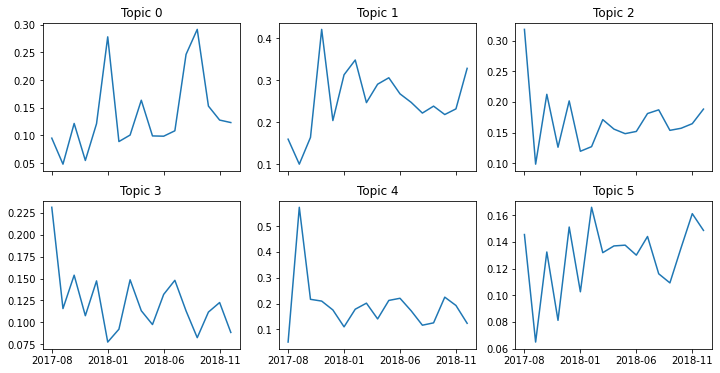

In [43]:
topic_titles = ['Topic '+str(i) for i in range(6)]
fig, axes = plt.subplots(2, 3, sharex='col', figsize=(12, 6)) 
for i, (title, ax) in enumerate(zip(topic_titles, axes.ravel())): 
    ax.set_title(title)
    ax.set_xticks([0, 5, 10, 15])
    ax.set_xticklabels(time_tag[::5])
    ax.plot(topic_trends[:, i])
plt.show()